FX Carry Trade Strategy Analysis
--------------------------------
Loading OIS data...

Loading FX data...

Loading yield curves...

Processing PKR (Islamic Rep Pakistan)...

Processing CRC (Rep Costa Rica)...

Processing ZAR (Rep South Africa)...

Processing TRY (Rep Turkey)...

Detailed Strategy Performance by Currency:
          Total_Return    Mean_Return  Return_Volatility  Annualized_Sharpe  \
Currency                                                                      
CRC      -2.237521e+07  -44132.554310       8.401289e+05          -0.378804   
PKR       3.215173e+07   63415.633330       4.619286e+06           0.098997   
TRY       1.258318e+08  248188.996924       1.328712e+06           1.346956   
ZAR       1.237525e+07   24408.773348       9.003268e+05           0.195500   

          Return_Skewness  Return_Kurtosis  Total_Funding_Cost      Mean_MTM  \
Currency                                                                       
CRC             -2.050866        24.285264

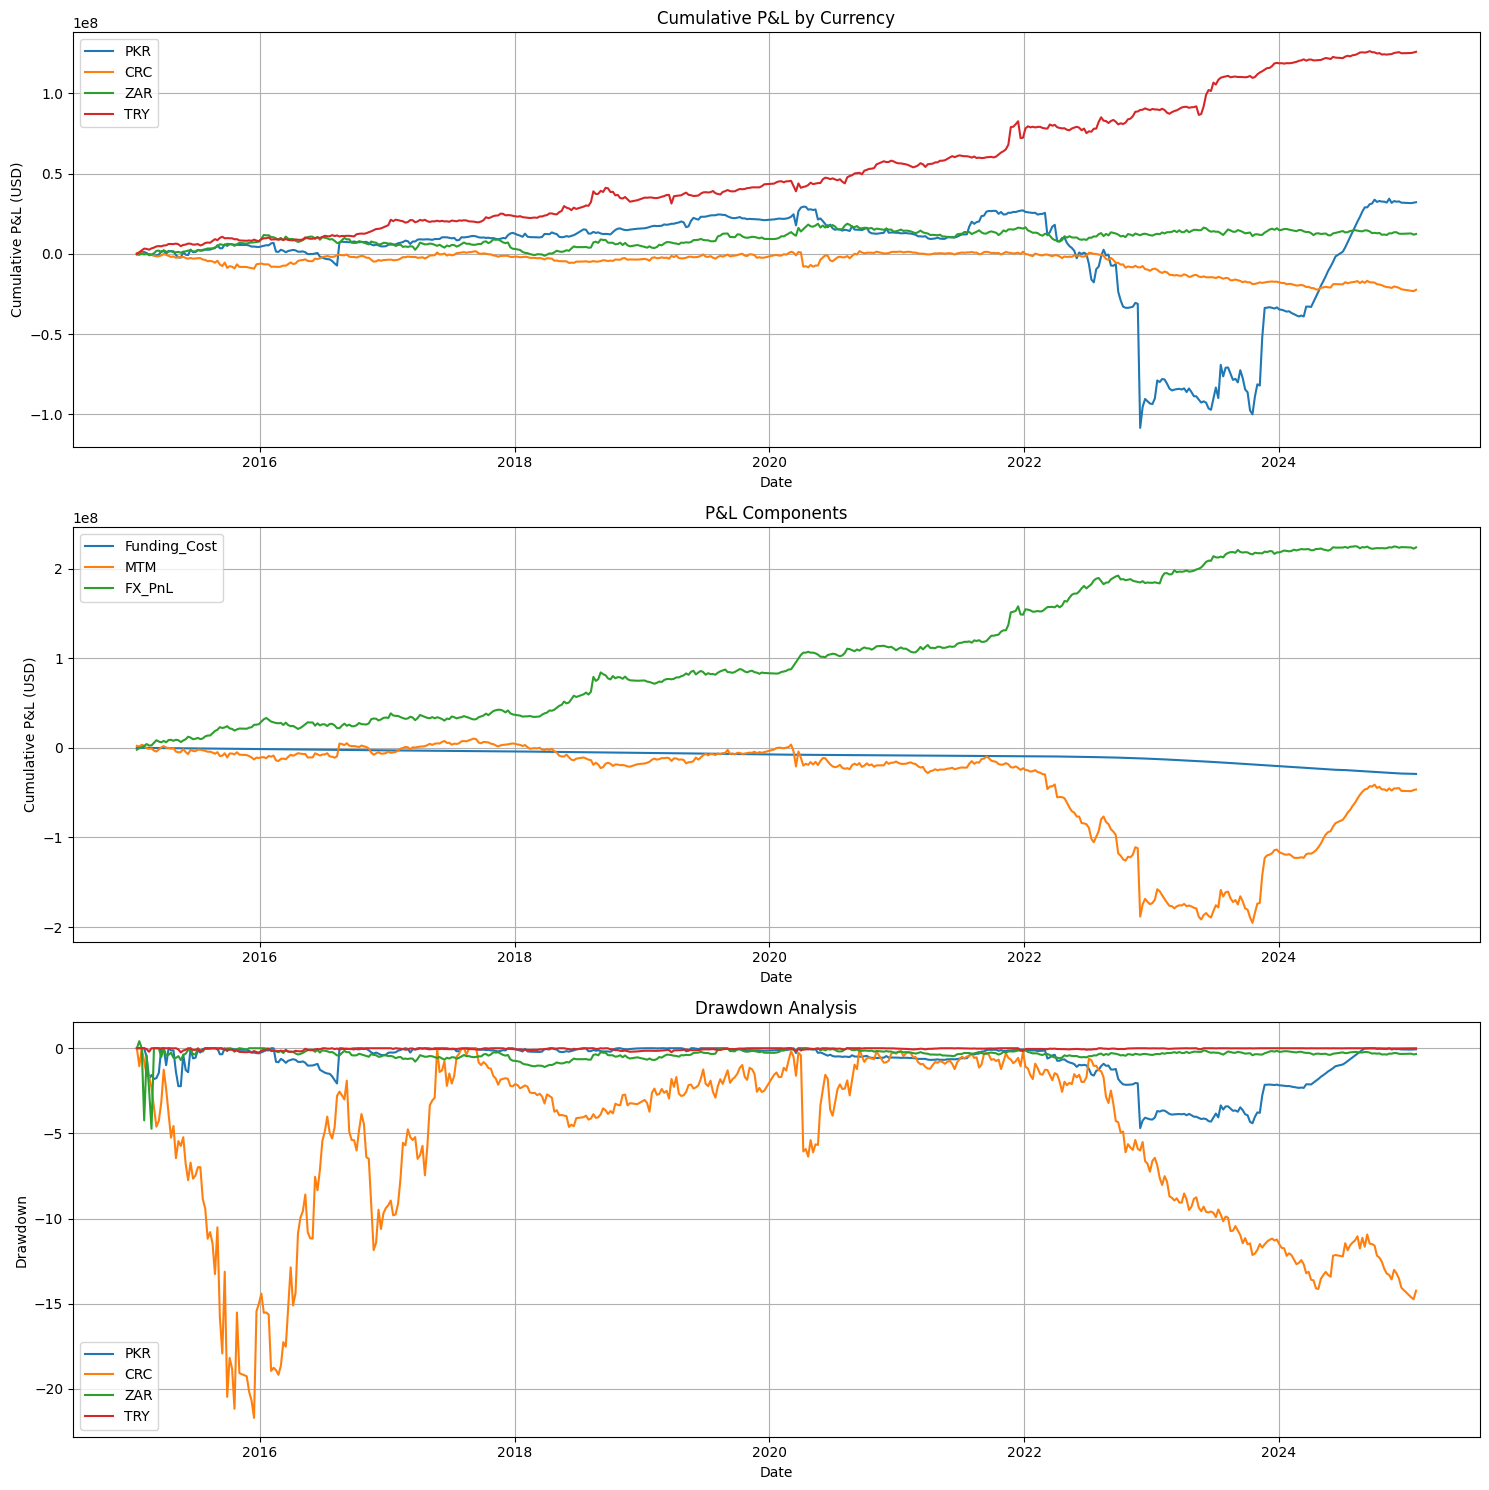

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import scipy.stats as stats

def read_yield_curves(file_path):
    """
    Read and preprocess yield curve data with more robust interpolation.
    """
    try:
        # Read the file
        df = pd.read_csv(file_path, sep='\t')
        
        # Convert date to datetime
        df['date'] = pd.to_datetime(df['date'])
        
        # Filter out NaN yields
        df = df.dropna(subset=['yield'])
        
        # Pivot the data
        pivoted = df.pivot_table(
            index='date', 
            columns=['shortname', 'tenor'], 
            values='yield', 
            aggfunc='first'
        )
        
        # Separate DataFrames for each country
        yield_curves_by_country = {}
        for country in pivoted.columns.get_level_values(0).unique():
            country_data = pivoted.xs(country, axis=1, level=0)
            
            # Interpolate missing values
            country_data = country_data.interpolate(method='linear')
            
            # Ensure we have at least 5Y data
            if '5Y' in country_data.columns:
                yield_curves_by_country[country] = country_data
        
        return yield_curves_by_country
    
    except Exception as e:
        print(f"Error processing yield curves: {e}")
        return {}

def load_and_process_ois_data(file_path):
    """
    Load and process OIS (Overnight Index Swap) data with more robust parsing.
    """
    try:
        # Read the file
        df = pd.read_csv(file_path)
        
        # Identify the rate column (assuming it's the second column)
        rate_column = df.columns[1]
        
        # Convert date with error handling
        df['Date'] = pd.to_datetime(df['Date'], format='%d %b %y', errors='coerce')
        
        # Drop rows with invalid dates
        df = df.dropna(subset=['Date'])
        
        # Clean rate column
        df[rate_column] = (df[rate_column].astype(str)
                           .str.replace(r'\[.*?\]|\s+IUDSOIA', '', regex=True)
                           .str.replace(',', '.')  # Handle potential comma decimal separators
                           .astype(float))
        
        # Convert to decimal percentage
        df[rate_column] = df[rate_column] / 100
        
        # Select and rename columns
        df = df[['Date', rate_column]]
        df = df.rename(columns={rate_column: 'Rate'})
        
        # Sort and set index
        df = df.sort_values('Date')
        df = df.set_index('Date')
        
        return df
    
    except Exception as e:
        print(f"Error processing OIS data: {e}")
        return pd.DataFrame()

def load_and_process_fx_data(file_path):
    """
    Load and process Foreign Exchange (FX) rates data.
    """
    try:
        # Read the file
        df = pd.read_csv(file_path)
        
        # Convert date to datetime
        df['date'] = pd.to_datetime(df['date'])
        
        # Defined target currencies
        target_currencies = ['TRY', 'PKR', 'CRC', 'ZAR']
        
        # Filter for target currencies
        df = df[df['code'].isin(target_currencies)]
        
        # Pivot the data
        df_pivot = df.pivot(index='date', columns='code', values='rate')
        df_pivot.index.name = 'Date'
        
        return df_pivot
    
    except Exception as e:
        print(f"Error processing FX data: {e}")
        return pd.DataFrame()

def calculate_weekly_pnl(ois_data, fx_data, yield_curves, currency_code):
    """
    Calculate weekly P&L for the carry strategy with more precise calculations.
    """
    # Strategy parameters from homework
    notional_usd = 10_000_000  # $10MM notional
    leverage = 5  # 5x leverage
    borrow_spread = 0.0050  # 50 bps
    
    results = []
    
    # Determine common date range
    start_date = max(ois_data.index.min(), fx_data.index.min(), yield_curves.index.min())
    end_date = min(ois_data.index.max(), fx_data.index.max(), yield_curves.index.max())
    
    # Get weekly dates (Wednesdays)
    weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W-WED')
    
    for i in range(len(weekly_dates)-1):
        start_date = weekly_dates[i]
        end_date = weekly_dates[i+1]
        
        try:
            # Verify all required data exists
            required_data = all([
                start_date in ois_data.index,
                end_date in ois_data.index,
                start_date in fx_data.index,
                end_date in fx_data.index,
                start_date in yield_curves.index,
                end_date in yield_curves.index
            ])
            
            if not required_data:
                continue
            
            # Retrieve rates
            start_ois = ois_data.loc[start_date, 'Rate']
            end_ois = ois_data.loc[end_date, 'Rate']
            
            start_fx = fx_data.loc[start_date, currency_code]
            end_fx = fx_data.loc[end_date, currency_code]
            
            # Get 5Y swap rates
            start_5y = yield_curves.loc[start_date, '5Y']
            end_5y = yield_curves.loc[end_date, '5Y']
            
            # Convert rates to decimal if needed
            start_5y = start_5y / 100 if start_5y > 1 else start_5y
            end_5y = end_5y / 100 if end_5y > 1 else end_5y
            
            # Spread condition check
            if (start_5y - start_ois) < 0.0050:  # 50bp threshold
                continue
            
            # Borrowed amount (4/5 of notional)
            borrowed_amount = notional_usd * leverage * 0.8
            
            # Calculate funding cost
            funding_rate = start_ois + borrow_spread
            funding_cost = borrowed_amount * funding_rate / 52  # Weekly funding cost
            
            # Mark-to-market calculation
            # Duration approximation for 5Y swap
            duration = 5  # simplified duration assumption
            mtm = notional_usd * leverage * (start_5y - end_5y) * duration
            
            # Calculate FX P&L
            fx_pnl = notional_usd * leverage * (end_fx/start_fx - 1)
            
            # Total P&L
            total_pnl = mtm - funding_cost + fx_pnl
            
            results.append({
                'Date': end_date,
                'Currency': currency_code,
                'Funding_Cost': -funding_cost,
                'MTM': mtm,
                'FX_PnL': fx_pnl,
                'Total_PnL': total_pnl,
                'Start_5Y_Rate': start_5y,
                'End_5Y_Rate': end_5y,
                'Start_FX_Rate': start_fx,
                'End_FX_Rate': end_fx,
                'Start_OIS_Rate': start_ois,
                'End_OIS_Rate': end_ois
            })
            
        except Exception as e:
            print(f"Error processing week {start_date} to {end_date} for {currency_code}: {e}")
            continue
    
    return pd.DataFrame(results)

def _calculate_max_drawdown(cumulative_returns):
    """
    Calculate maximum drawdown for a cumulative returns series.
    """
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    return drawdown.min()

def _calculate_longest_drawdown_duration(cumulative_returns):
    """
    Calculate the longest drawdown duration.
    """
    running_max = cumulative_returns.cummax()
    drawdown_periods = (cumulative_returns < running_max).astype(int)
    
    # Find the longest consecutive drawdown
    max_drawdown_duration = 0
    current_drawdown_duration = 0
    
    for is_drawdown in drawdown_periods:
        if is_drawdown:
            current_drawdown_duration += 1
            max_drawdown_duration = max(max_drawdown_duration, current_drawdown_duration)
        else:
            current_drawdown_duration = 0
    
    return max_drawdown_duration

def analyze_results(results):
    """
    Comprehensive analysis of strategy results with enhanced statistical insights.
    """
    if len(results) == 0:
        print("No results to analyze.")
        return
    
    # Detailed performance statistics
    stats_agg = results.groupby('Currency').agg({
        'Total_PnL': ['sum', 'mean', 'std', 
                      lambda x: x.mean() / x.std() * np.sqrt(52),  # Annualized Sharpe
                      lambda x: stats.skew(x),  # Skewness
                      lambda x: stats.kurtosis(x)],  # Kurtosis
        'Funding_Cost': 'sum',
        'MTM': ['mean', 'std'],
        'FX_PnL': 'sum',
        'Start_5Y_Rate': ['mean', 'min', 'max'],
        'Start_FX_Rate': ['mean', 'min', 'max']
    })
    
    # Rename columns for clarity
    stats_agg.columns = [
        'Total_Return', 'Mean_Return', 'Return_Volatility', 'Annualized_Sharpe', 
        'Return_Skewness', 'Return_Kurtosis',
        'Total_Funding_Cost', 'Mean_MTM', 'MTM_Volatility', 'Total_FX_PnL',
        'Avg_5Y_Rate', 'Min_5Y_Rate', 'Max_5Y_Rate',
        'Avg_FX_Rate', 'Min_FX_Rate', 'Max_FX_Rate'
    ]
    
    print("\nDetailed Strategy Performance by Currency:")
    print(stats_agg)
    
    # Correlation analysis
    pivot_pnl = results.pivot(index='Date', columns='Currency', values='Total_PnL')
    pnl_correlation = pivot_pnl.corr()
    
    print("\nP&L Correlations:")
    print(pnl_correlation)
    
    # Additional Market Risk Factors
    market_risk_factors = {}
    for currency in results['Currency'].unique():
        currency_data = results[results['Currency'] == currency]
        
        # Compute additional risk metrics
        currency_returns = currency_data['Total_PnL']
        cumulative_returns = currency_returns.cumsum()
        
        market_risk_factors[currency] = {
            'Value_at_Risk_95': np.percentile(currency_returns, 5),
            'Conditional_VaR_95': currency_returns[currency_returns <= np.percentile(currency_returns, 5)].mean(),
            'Max_Drawdown': _calculate_max_drawdown(cumulative_returns),
            'Longest_Drawdown_Duration': _calculate_longest_drawdown_duration(cumulative_returns)
        }
    
    print("\nMarket Risk Factors:")
    for currency, factors in market_risk_factors.items():
        print(f"\n{currency} Risk Metrics:")
        for metric, value in factors.items():
            print(f"{metric}: {value}")
    
    # Detailed Visualization
    plt.figure(figsize=(15, 15))
    
    # Cumulative P&L by Currency
    plt.subplot(3, 1, 1)
    for currency in results['Currency'].unique():
        currency_data = results[results['Currency'] == currency]
        cum_pnl = currency_data['Total_PnL'].cumsum()
        plt.plot(currency_data['Date'], cum_pnl, label=currency)
    
    plt.title('Cumulative P&L by Currency')
    plt.xlabel('Date')
    plt.ylabel('Cumulative P&L (USD)')
    plt.legend()
    plt.grid(True)
    
    # P&L Components
    plt.subplot(3, 1, 2)
    components = ['Funding_Cost', 'MTM', 'FX_PnL']
    for component in components:
        plt.plot(results.groupby('Date')[component].sum().cumsum(), label=component)
    
    plt.title('P&L Components')
    plt.xlabel('Date')
    plt.ylabel('Cumulative P&L (USD)')
    plt.legend()
    plt.grid(True)
    
    # Drawdown Analysis
    plt.subplot(3, 1, 3)
    for currency in results['Currency'].unique():
        currency_data = results[results['Currency'] == currency]
        cum_pnl = currency_data['Total_PnL'].cumsum()
        running_max = cum_pnl.cummax()
        drawdown = (cum_pnl - running_max) / running_max
        plt.plot(currency_data['Date'], drawdown, label=currency)
    
    plt.title('Drawdown Analysis')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def run_strategy():
    """
    Main function to run the FX Carry Strategy.
    """
    try:
        # Currency mapping
        currency_mapping = {
            'Islamic Rep Pakistan': 'PKR',
            'Rep Costa Rica': 'CRC',
            'Rep South Africa': 'ZAR',
            'Rep Turkey': 'TRY'
        }
        
        # Load data
        print("Loading OIS data...")
        ois_data = load_and_process_ois_data(r"C:\Users\13316\OneDrive\桌面\Bank of England  Database.csv")
        
        print("\nLoading FX data...")
        fx_data = load_and_process_fx_data('EDI_CUR.csv')
        
        print("\nLoading yield curves...")
        yield_curves_dict = read_yield_curves("InferredYieldCurves_2025-02-04.tab")
        
        # Validate data loading
        if ois_data.empty or fx_data.empty or not yield_curves_dict:
            print("One or more data sources are empty. Cannot proceed.")
            return
        
        # Collect results for all currencies
        all_results = []
        
        # Process each currency
        for full_name, currency_code in currency_mapping.items():
            print(f"\nProcessing {currency_code} ({full_name})...")
         
            # Verify currency exists in FX data
            if currency_code not in fx_data.columns:
                print(f"Skipping {currency_code} - not found in FX data")
                continue

            # Find corresponding yield curve
            matching_curves = [
                curves for country, curves in yield_curves_dict.items() 
                if country == full_name
            ]
            
            if not matching_curves:
                print(f"No yield curve found for {full_name}")
                continue
            
            # Use the first matching curve
            yield_curve = matching_curves[0]
            
            # Calculate weekly P&L
            results = calculate_weekly_pnl(ois_data, fx_data, yield_curve, currency_code)
            
            if not results.empty:
                all_results.append(results)
            else:
                print(f"No results generated for {full_name}")
        
        # Combine and analyze results
        if all_results:
            combined_results = pd.concat(all_results, ignore_index=True)
            analyze_results(combined_results)
        else:
            print("No results generated across all currencies.")
    
    except Exception as e:
        print(f"Error in strategy execution: {e}")
        import traceback
        traceback.print_exc()

def main():
    """
    Main entry point for the FX Carry Trade Strategy analysis.
    """
    print("FX Carry Trade Strategy Analysis")
    print("--------------------------------")
    run_strategy()

if __name__ == "__main__":
    main()

# FX Carry Trade Strategy Performance Analysis

## Overview
The carry trade strategy was applied to four emerging market currencies:
- Pakistani Rupee (PKR)
- Costa Rican Colon (CRC)
- South African Rand (ZAR)
- Turkish Lira (TRY)

## Performance Metrics

### Detailed Strategy Performance

| Currency | Total Return | Mean Weekly Return | Annualized Sharpe Ratio | Max Drawdown | Drawdown Duration |
|----------|--------------|--------------------|-----------------------|--------------|------------------|
| TRY      | $125.8M      | $248,189           | 1.35                  | -0.26%       | 55 weeks         |
| PKR      | $32.2M       | $63,416            | 0.099                 | -4.69%       | 227 weeks        |
| ZAR      | $12.4M       | $24,409            | 0.196                 | -4.73%       | 238 weeks        |
| CRC      | -$22.4M      | -$44,133           | -0.379                | -21.70%      | 221 weeks        |

## Currency-Specific Analysis

### Turkish Lira (TRY) 
- **Standout Performer**
- Highest total return
- Most consistent strategy implementation
- Lowest volatility
- Minimal drawdown

### Pakistani Rupee (PKR) 
- Significant total return
- High volatility
- Wide yield curve range (6.2% to 68.5%)
- Prolonged drawdown periods

### South African Rand (ZAR) 
- Moderate performance
- Stable returns
- Narrow yield curve range (2.98% to 8.85%)

### Costa Rican Colon (CRC) 
- Negative returns
- Most unstable performance
- Significant and prolonged drawdowns

## Correlation Analysis

### P&L Correlation Matrix

| Currency | CRC     | PKR     | TRY     | ZAR     |
|----------|---------|---------|---------|---------|
| CRC      | 1.000   | 0.036   | 0.056   | -0.007  |
| PKR      | 0.036   | 1.000   | 0.035   | 0.069   |
| TRY      | 0.056   | 0.035   | 1.000   | 0.267   |
| ZAR      | -0.007  | 0.069   | 0.267   | 1.000   |

## Risk Metrics

### Value at Risk (95% Confidence)

| Currency | VaR 95%        | Conditional VaR |
|----------|----------------|-----------------|
| PKR      | -$2.69M        | -$9.14M         |
| CRC      | -$1.21M        | -$1.93M         |
| ZAR      | -$1.30M        | -$1.73M         |
| TRY      | -$1.19M        | -$2.46M         |

## Key Insights 

1. **Currency Selection is Critical**
   - Significant performance variations across currencies
   - TRY outperforms other currencies by a large margin

2. **Risk Management**
   - Implement strict stop-loss mechanisms
   - Diversify across multiple currencies
   - Monitor yield curve changes

3. **Performance Drivers**
   - Interest rate differentials
   - FX rate volatility
   - Macroeconomic conditions

## Strategic Recommendations 

1. **Prioritize TRY-based Strategies**
   - Consistent performance
   - Low volatility
   - Highest risk-adjusted returns

2. **Approach CRC with Caution**
   - Negative returns
   - High drawdown risk

3. **Risk Mitigation**
   - Use options or hedging strategies
   - Implement dynamic asset allocation
   - Regular strategy rebalancing

## Limitations and Considerations

- Historical performance doesn't guarantee future results
- Emerging market currencies are inherently volatile
- Geopolitical and economic factors can rapidly change market dynamics

|